### Импорт библиотек

In [1]:
import numpy as np 
import pandas as pd
import missingno as msno
from collections import Counter
import time, datetime
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import seaborn as sns
import scipy.sparse as sparse
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split,GridSearchCV
from lightfm.evaluation import precision_at_k, recall_at_k
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import ttest_ind
import nmslib

E:\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


### Импорт данных

In [2]:
#Читаем файлы
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

#Сразу удалим дубликаты из train
train = train.drop_duplicates()

#У нас также есть большой файл в json-формате. Считаем его и запишем в отдельный датасет
with open('meta_Grocery_and_Gourmet_Food.json') as f:
    json_data = []
    for item in f.readlines():
        json_data.append(json.loads(item))
        
meta = pd.DataFrame(json_data)
meta.drop_duplicates(subset=['asin'],inplace=True)

train['sample'] = 1 
test['sample'] = 0 
test['rating'] = 0

# Объединим тренировочный и тестовый датасет, а затем добавим к ним данные из json-файла.
train_merged = pd.merge(train,meta,on='asin',how='left')
test_merged = pd.merge(test,meta,on='asin',how='left')
df = train_merged.append(test_merged, sort=False).reset_index() # объединяем
#df = pd.merge(df,meta,on='asin',how='left')

E:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
E:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
test_merged

,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,style,image_x,userid,itemid,...,main_cat,price,also_buy,image_y,date,feature,details,similar_item,tech1,fit
0,True,"10 1, 2016",B001E5E3X0,Rudys Mom,1475280000,NaN,NaN,NaN,68877,7506,...,Grocery,$39.05,"[B005P7YSG0, B005P7YQ7Q, B001M0A8Y0, B004AM21B...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
1,True,"06 29, 2014",B005BYXX5E,pharg,1404000000,2,NaN,NaN,50442,15530,...,Grocery,$5.45,NaN,NaN,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
2,True,"05 19, 2015",B0052OK6OO,dhalex,1431993600,NaN,NaN,NaN,64349,15049,...,Grocery,$54.96,NaN,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
3,True,"10 5, 2014",B003SO8HGE,Vanessa,1412467200,NaN,{'Flavor:': ' Sweet Rose'},NaN,26206,11957,...,Health & Personal Care,$10.56,"[B004GW8LBI, B005P0U9CE, B00399D3Y4, B004YB3WG...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: ...",NaN,NaN,NaN
4,True,"11 11, 2013",B003XUJ564,R Mohrman,1384128000,3,"{'Size:': ' 15 Ounce (Pack of 12)', 'Flavor:':...",NaN,59366,12173,...,Grocery,$30.96,"[B00DOSIT5I, B01L8LG6MU, B0014EW4N2, B00M9C14U...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: ...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285960,True,"01 17, 2016",B00FLD3X28,A. Banks,1452988800,NaN,{'Size:': ' 1 Pound'},NaN,294,25601,...,Grocery,$10.99,"[B01LBILGYS, B009L3HWV2, B00VL9Q4WW, B01MT9DCQ...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Size: <s...",NaN,NaN,NaN
285961,True,"08 22, 2015",B0078DQ85S,HighEnergy,1440201600,NaN,{'Flavor:': ' Cinnamon & Currant'},NaN,119653,18204,...,Grocery,$4.48,"[B01MZIHO8Z, B017BR91GI, B0799CH1ZZ, B01MU22JS...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: ...",NaN,NaN,NaN
285962,True,"09 21, 2017",B000FZVLFS,Sam Jackson,1505952000,NaN,{'Flavor:': ' Espresso Forte'},NaN,54673,2287,...,Grocery,$9.39,"[B007T2MW6M, B007T2MW76, B00P0ZMWEC, B005GBXKS...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
285963,True,"03 27, 2018",B001PB801Y,Louis J. Dezseran Sr.,1522108800,NaN,{'Size:': ' 5lb'},NaN,16569,9343,...,Grocery,$13.99,"[B001PB1D4K, B001PB2ZP6, B01BP74VQU, B00IED712...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Size: <s...",NaN,NaN,NaN


### Функции

In [4]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'rating'], df.loc[df.loc[:, column] == comb[1], 'rating']).pvalue <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

### Оценка и первичная обработка данных

    Итак, начнем с ответа на вопрос - а что же наш магазин продает? Для этого посмотрим на первые 10 строк тренировочных данных

In [5]:
df.head(10)

,index,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,...,price,also_buy,image_y,date,feature,details,similar_item,tech1,fit,Id
0,0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,...,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN,NaN
1,1,5.0,True,"03 1, 2016",B006F63M8U,Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,...,$18.49,"[B001FBKO4U, B00BJ9URYA, B00451ZJB0, B0017TMTF...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Size: <s...",NaN,NaN,NaN,NaN
2,2,5.0,True,"06 26, 2016",B00112O8NG,DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,...,NaN,"[B000T9WLUY, B01K23RF7U, B0015GSBUY, B00112KVN...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN,NaN
3,3,5.0,True,"09 5, 2013",B00MRAQUM8,Connie L. Reaves,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,...,$44.95,"[B00416T7E4, B0001M11DC, B001VNO1NM, B01CRXAYK...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Pattern ...",NaN,NaN,NaN,NaN
4,4,5.0,True,"09 14, 2016",B000R7RN0G,Mike P.,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,...,NaN,"[B000R7XBF2, B000HIFA8W, B000R7RODW, B07BDQGY1...",[https://images-na.ssl-images-amazon.com/image...,NaN,[64 count of MISS VICKIE'S Kettle Cooked Jalap...,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: ...",NaN,NaN,NaN,NaN
5,5,5.0,True,"02 24, 2014",B0009F3PM6,indy,"If you are tired of peppermint blends, this is...",best tea ever!!!,1393200000,NaN,...,$23.94,"[B0089VPTZ8, B007IW25FQ, B0009JQK9C, B009S7NOX...",[https://images-na.ssl-images-amazon.com/image...,NaN,[Non-GMO Project verified; All Ingredients Cer...,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: ...",NaN,NaN,NaN,NaN
6,6,5.0,True,"07 1, 2014",B005HGOIQ4,Barbara,Tastes really close to sugar and it's a great ...,True sugar taste,1404172800,NaN,...,$26.10,"[B00BSZBEAG, B00PRGU6BA, B005HI55CS, B004KUV13...",[https://images-na.ssl-images-amazon.com/image...,NaN,"[1:1 Replacement For Refined Sugar, Great in B...","\n\n\n\n\n\n <div class=""disclaim"">Flavor: ...",NaN,NaN,NaN,NaN
7,7,5.0,True,"02 20, 2017",B000WG7M76,JoAnne G..,Thrilled to find sugar free Reese's Peanut But...,Five Stars,1487548800,NaN,...,$6.49,"[B00DR7BLV0, B0079OYBWI, B0070F5BS4, B001R1DW4...",[https://images-na.ssl-images-amazon.com/image...,NaN,[Heat oven to 375F. Remove wrappers from candi...,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN,NaN
8,8,5.0,True,"01 25, 2013",B00117YT4Y,Surra,"I have tried a few other brands, but this powd...",low carb goodness,1359072000,NaN,...,$15.77,"[B00QEMUPI0, B00QEMUP58, B01N4U6EDR, B00B1M1WL...",[https://images-na.ssl-images-amazon.com/image...,NaN,[Designer Whey has been endorsed for its taste...,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: ...",NaN,NaN,NaN,NaN
9,9,4.0,False,"06 8, 2012",B0146RYG02,Girlfriend Recommends,I fell in love with the chocolate version of t...,"Tasty, but there's a better version!",1339113600,2,...,$24.79,"[B000LQLMVY, B077MBR736, B002V0H3VQ, B000LQNCE...",NaN,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN,NaN


У нас нет столбца с конкретными наименованиями товара, но есть любопытный признак asin. Судя по всему, это товары с Amazon.
Теперь посмотрим на техническую сторону данных, а именно на их размер, колонки, и количество пропусков.

index                   0
overall            285965
verified                0
reviewTime              0
asin                    0
reviewerName          211
reviewText         286239
summary            286131
unixReviewTime          0
vote               959447
style              537955
image_x           1105506
userid                  0
itemid                  0
rating                  0
sample                  0
category                0
description         94669
title                   0
brand                8190
rank                46705
also_view          512884
main_cat             1289
price              338374
also_buy           160014
image_y            120333
date              1099233
feature            925801
details             18888
similar_item      1113356
tech1             1109102
fit               1114900
Id                 828935
dtype: int64

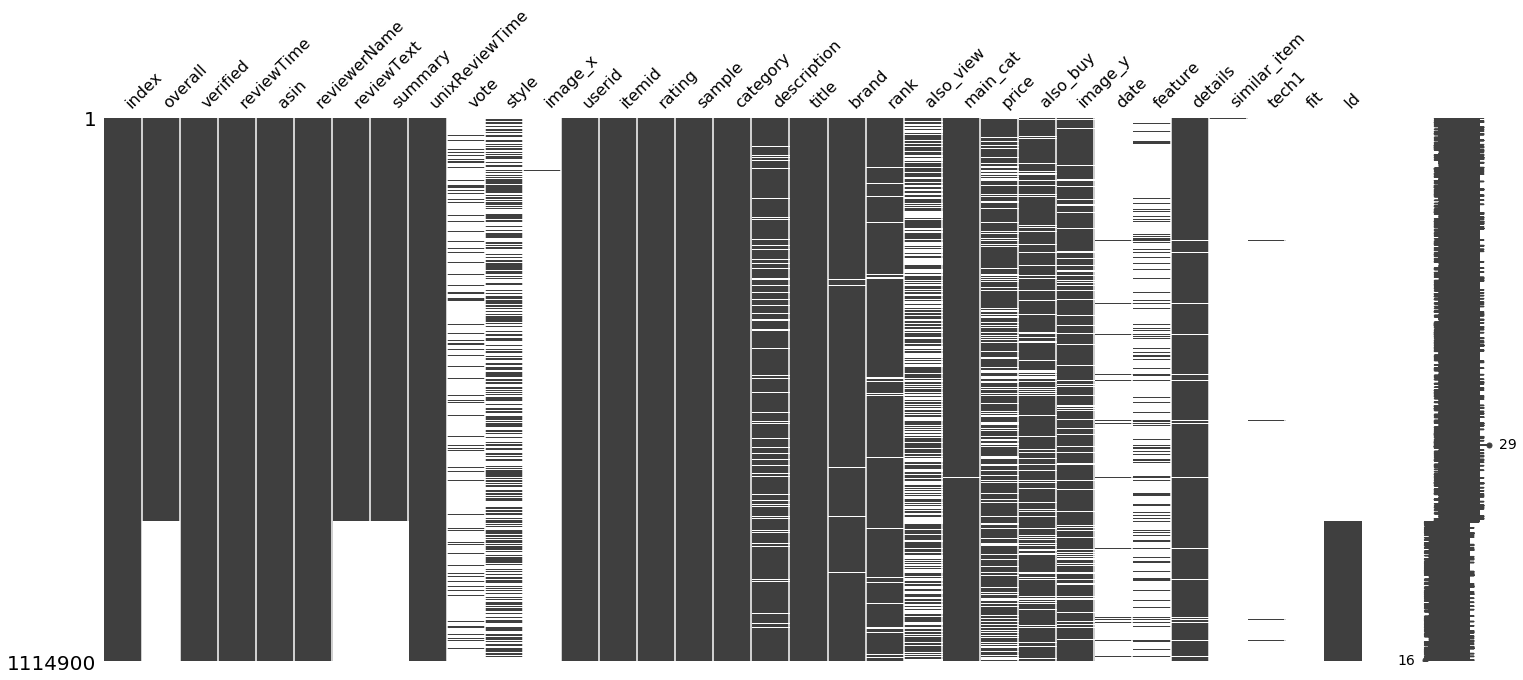

In [6]:
display(msno.matrix(df))
display(df.isnull().sum())

Нам придется выкинуть признаки, в которых пропущено слишком много данных, и/или их нет в тестовом датасете: overall,reviewerName,reviewText,summary,vote,style,image_x,id,descriprion,also_view,also_buy,image_y,date,feature,similar_item,tech1,fit

In [7]:
# Очищаем тренировочные данные
df.drop(['vote',
         'overall',
         'reviewerName',
         'reviewText',
         'summary',
         'vote',
         'style',
         'image_x',
         'Id',
         'description',
         'also_view',
         'also_buy',
         'image_y',
         'date',
         'feature',
         'similar_item',
         'tech1',
         'fit',
         'price',
         'index'], inplace=True, axis=1)

verified              0
reviewTime            0
asin                  0
unixReviewTime        0
userid                0
itemid                0
rating                0
sample                0
category              0
title                 0
brand              8190
rank              46705
main_cat           1289
details           18888
dtype: int64

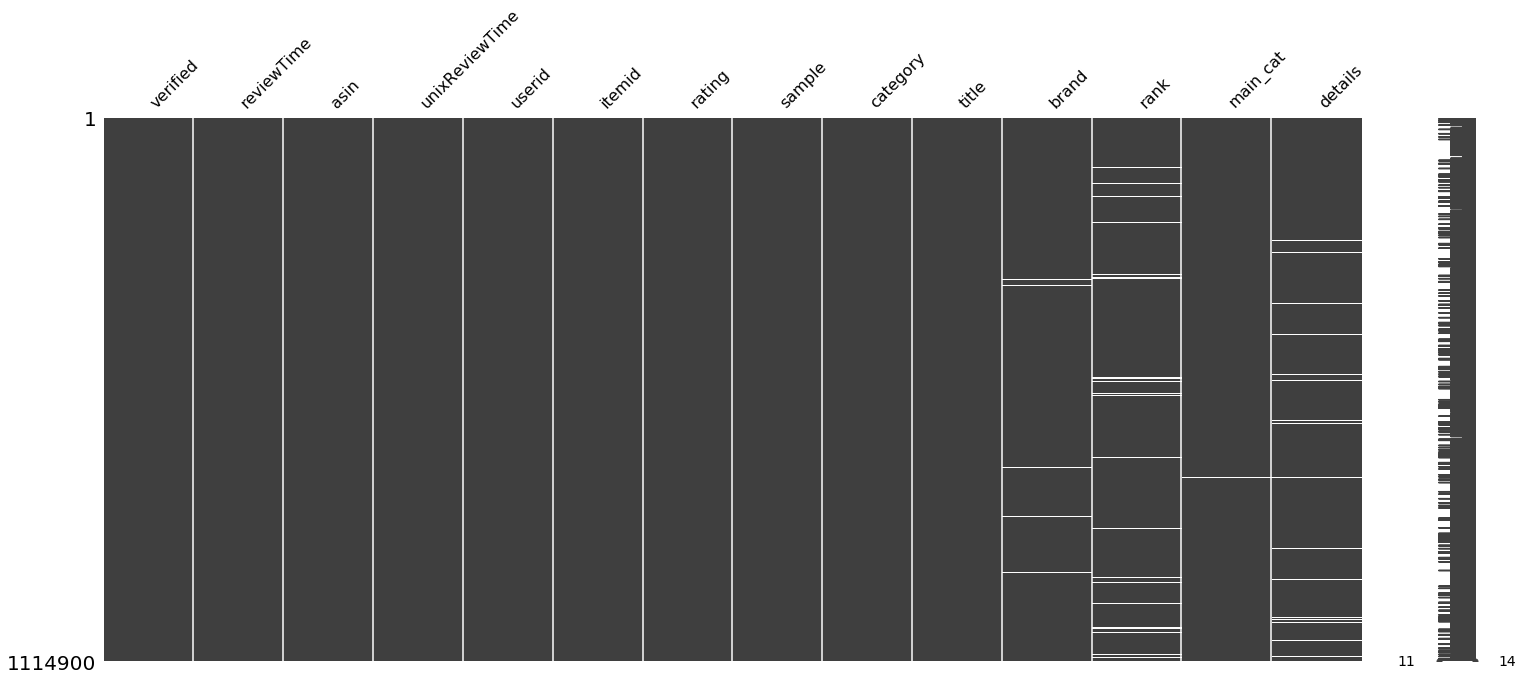

In [8]:
#Посмотрим еще раз.

display(msno.matrix(df))
display(df.isnull().sum())

### Категоризация данных

Вот с такими данными можно работать! Теперь, когда первичная обработка завершена, можем взглянуть на данные более детально. 

In [9]:
df[df['sample']==0]

,verified,reviewTime,asin,unixReviewTime,userid,itemid,rating,sample,category,title,brand,rank,main_cat,details
828935,True,"10 1, 2016",B001E5E3X0,1475280000,68877,7506,0.0,0,"[Grocery & Gourmet Food, Canned, Jarred & Pack...",var aPageStart = (new Date()).getTime();\nvar ...,Panni,"51,991inGroceryGourmetFood(",Grocery,"\n <div class=""content"">\n\n\n\n\n\n\n<ul..."
828936,True,"06 29, 2014",B005BYXX5E,1404000000,50442,15530,0.0,0,"[Grocery & Gourmet Food, Dried Beans, Grains &...",Anasazi Beans 1 lb burlap bag,Adobe Milling,"127,103inGroceryGourmetFood(",Grocery,"\n <div class=""content"">\n\n\n\n\n\n\n<ul..."
828937,True,"05 19, 2015",B0052OK6OO,1431993600,64349,15049,0.0,0,"[Grocery & Gourmet Food, Beverages, Coffee, Te...","Green Mountain Coffee, Kenya Keurig K-Cup Pods...",Green Mountain Coffee Roasters,"207,107inGroceryGourmetFood(",Grocery,"\n <div class=""content"">\n\n\n\n\n\n\n<ul..."
828938,True,"10 5, 2014",B003SO8HGE,1412467200,26206,11957,0.0,0,"[Grocery & Gourmet Food, Beverages, Coffee, Te...","Organic India Tulsi Tea, Loose Leaf, Sweet Ros...",ORGANIC INDIA,"68,308inHealthHousehold(",Health & Personal Care,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: ..."
828939,True,"11 11, 2013",B003XUJ564,1384128000,59366,12173,0.0,0,"[Grocery & Gourmet Food, Canned, Jarred & Pack...",Chef Boyardee Overstuffed Italian Sausage Ravi...,Chef Boyardee,"6,931inGroceryGourmetFood(",Grocery,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114895,True,"01 17, 2016",B00FLD3X28,1452988800,294,25601,0.0,0,"[Grocery & Gourmet Food, Cooking & Baking, Sug...","Natural Mate Sweetener, Sucralose and Erythrit...",Natural Mate,"39,264inGroceryGourmetFood(",Grocery,"\n\n\n\n\n\n <div class=""disclaim"">Size: <s..."
1114896,True,"08 22, 2015",B0078DQ85S,1440201600,119653,18204,0.0,0,"[Grocery & Gourmet Food, Snack Foods, Crackers...","Doctor In The Kitchen, Flackers Organic Flax S...",Doctor In The Kitchen,"5,074inGroceryGourmetFood(",Grocery,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: ..."
1114897,True,"09 21, 2017",B000FZVLFS,1505952000,54673,2287,0.0,0,"[Grocery & Gourmet Food, Beverages, Coffee, Te...","Peet's Coffee, French Roast Dark Roast, Whole ...",Peet's Coffee,NaN,Grocery,"\n <div class=""content"">\n\n\n\n\n\n\n<ul..."
1114898,True,"03 27, 2018",B001PB801Y,1522108800,16569,9343,0.0,0,"[Grocery & Gourmet Food, Produce, Dried Fruits...",Two Pounds Of Dates Pitted - We Got Nuts,We Got Nuts,"60,329inGroceryGourmetFood(",Grocery,"\n\n\n\n\n\n <div class=""disclaim"">Size: <s..."


Видно, что у нас есть признаки нескольких типов:     
    2) Один текстовый - title   
    3) Два временных - reviewTime и unixReviewTime
    4) Два бинарных - verified и rating
    5) Все остальные признаки - категориальные
        
Также удалим еще один признак - details. Это просто ненужный набор кода (или нет, но времени разбирать такой признак, к сожалению, не остается).
   
   

In [10]:
#Создаем экземпляр LabelEncoder для перевода признаков в бинарный формат
label_encoder = LabelEncoder()

#Обрабатываем признаки reviewTime и verified
df['reviewTime'] = pd.to_datetime(df['reviewTime'])
df['verified'] = label_encoder.fit_transform(df['verified'])

#Переводим столбец rating в из float в int64
df['rating'] =df['rating'].apply(lambda x:int(x))

In [11]:
#Удаляем признак details
df.drop('details', inplace=True, axis=1)

In [12]:
df

,verified,reviewTime,asin,unixReviewTime,userid,itemid,rating,sample,category,title,brand,rank,main_cat
0,1,2016-10-04,B01CPNIEQG,1475539200,102179,37138,1,1,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...","Primal Palate Organic Spices Adobo Seasoning, ...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(",Grocery
1,1,2016-03-01,B006F63M8U,1456790400,3625,17322,1,1,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",Milk Chocolate Swiss Miss Hot Cocoa Mix 60-0.7...,Swiss Miss,"5,591inGroceryGourmetFood(",Grocery
2,1,2016-06-26,B00112O8NG,1466899200,39495,5600,1,1,"[Grocery & Gourmet Food, Beverages, Bottled Be...","Torani Syrup, Sugar Free Vanilla, 25.4 oz",Torani,NaN,Grocery
3,1,2013-09-05,B00MRAQUM8,1378339200,72854,30249,1,1,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",Frontier Herb Organic Powdered Ceylon Cinnamon...,Frontier,"168,917inGroceryGourmetFood(",Grocery
4,1,2016-09-14,B000R7RN0G,1473811200,74859,4349,1,1,"[Grocery & Gourmet Food, Snack Foods, Chips & ...",Miss Vickie's Jalapeño Flavored Kettle Cooked ...,Miss Vickie's,"61,690inGroceryGourmetFood(",Grocery
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114895,1,2016-01-17,B00FLD3X28,1452988800,294,25601,0,0,"[Grocery & Gourmet Food, Cooking & Baking, Sug...","Natural Mate Sweetener, Sucralose and Erythrit...",Natural Mate,"39,264inGroceryGourmetFood(",Grocery
1114896,1,2015-08-22,B0078DQ85S,1440201600,119653,18204,0,0,"[Grocery & Gourmet Food, Snack Foods, Crackers...","Doctor In The Kitchen, Flackers Organic Flax S...",Doctor In The Kitchen,"5,074inGroceryGourmetFood(",Grocery
1114897,1,2017-09-21,B000FZVLFS,1505952000,54673,2287,0,0,"[Grocery & Gourmet Food, Beverages, Coffee, Te...","Peet's Coffee, French Roast Dark Roast, Whole ...",Peet's Coffee,NaN,Grocery
1114898,1,2018-03-27,B001PB801Y,1522108800,16569,9343,0,0,"[Grocery & Gourmet Food, Produce, Dried Fruits...",Two Pounds Of Dates Pitted - We Got Nuts,We Got Nuts,"60,329inGroceryGourmetFood(",Grocery


### Обзор переменных

#### verified, rating

Для начала посмотрим на распределение нашей целевой переменной - rating

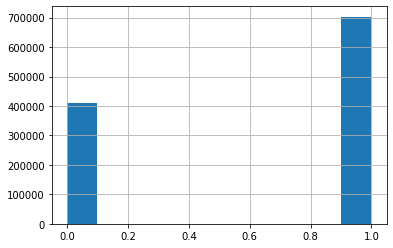

In [13]:
df.rating.hist()

In [14]:
df.rating.value_counts()

1    703165
0    411735
Name: rating, dtype: int64

Из получившейся картины можно сказать, что почти более 60% оценок  - положительные. Также стоит посмотреть, как с переменной rating коррелирует переменная verified. 

,rating,verified
rating,1.000000,0.038916
verified,0.038916,1.000000


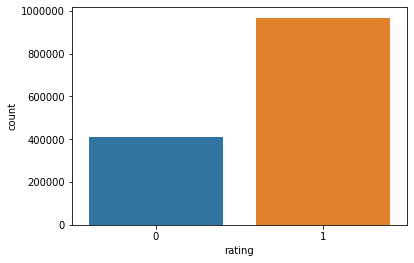

In [15]:
#Сравним распределение переменных и их корреляцию
display(sns.countplot(df.verified))
display(sns.countplot(df.rating))
df.rating.describe()

df_binaries = df[['rating','verified']]
df_binaries.corr()

Распределение переменных примерно одинаковое, однако корреляция слабая.

#### reviewTime

Этот признак мы можем сделать категориальным, выделив из него день год, месяц, день и день недели. Возможно, дата может как-то влиять на оценки пользователей. Проверим эту гипотезу.

In [16]:
df['weekday'] = df['reviewTime'].apply(lambda x:x.dayofweek)
df['day'] = df['reviewTime'].apply(lambda x:x.day)
df['month'] = df['reviewTime'].apply(lambda x:x.month)
df['year'] = df['reviewTime'].apply(lambda x:x.year)


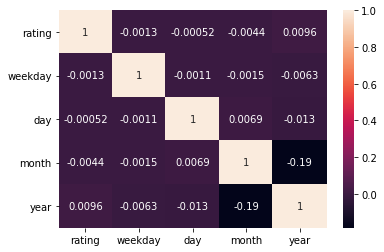

In [17]:
# Посмотрим на корреляцию переменных дат с rating и overall
display(sns.heatmap(df[['rating','weekday','day','month','year']].corr(), annot=True))

# Видно, что корреляций почти нет

In [18]:
# Сделаем маппинг для weekday
df['weekday'] = df['weekday'].map({0:'Monday', 
                                   1:'Tuesday', 
                                   2:'Wednesday', 
                                   3:'Thursday', 
                                   4:'Friday', 
                                   5:'Saturday', 
                                   6:'Sunday'})

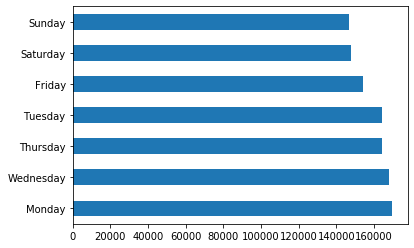

In [19]:
# И посмотрим на распределение признаков

display(df['weekday'].value_counts().plot.barh())

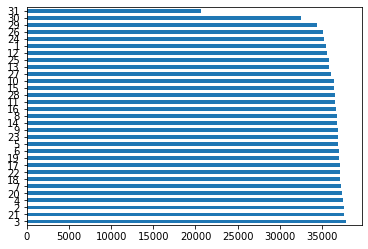

In [20]:
display(df['day'].value_counts().plot.barh())

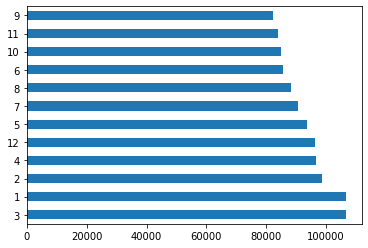

In [21]:
display(df['month'].value_counts().plot.barh())

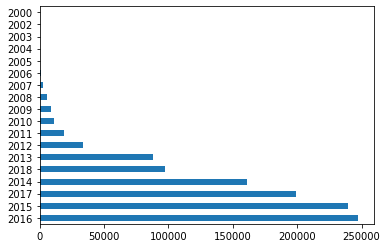

In [22]:
display(df['year'].value_counts().plot.barh())

Что можно извлечь из графиков выше:

1) с 2000 по 2006 год оценок почти не было, затем бизнес развивался и кол-во оценок (и заказов) росло в геометрической прогрессии, однако в 2016-м году рост затормозился;
2) Наибольшая активность пользователей наблюдается в понедельник и среду, наименьшая - в выходные;
3) 

#### unixReviewTime,asin,userid,itemid

Эти признаки не требуют дополнителной предобработки. asin вообще по сути нужен только для объединения данных

#### category, main_cat, rank

Судя по всему, эти переменные работают в связке:
    category представляет собой список категорий, к который можно отнести товар.
    Переменная rank - вес, присвоенный неким алгоритмом для этой категории.
    main category - категория, получившая по итогу наибольший вес.

Grocery                      1055102
Health & Personal Care         42908
Amazon Home                     9324
All Beauty                      1962
Sports & Outdoors               1489
Industrial & Scientific         1225
Office Products                  843
Toys & Games                     402
Pet Supplies                     169
Tools & Home Improvement          74
Baby                              50
Arts, Crafts & Sewing             25
Home Audio & Theater              11
Camera & Photo                     9
Musical Instruments                8
Software                           5
Cell Phones & Accessories          5
Name: main_cat, dtype: int64

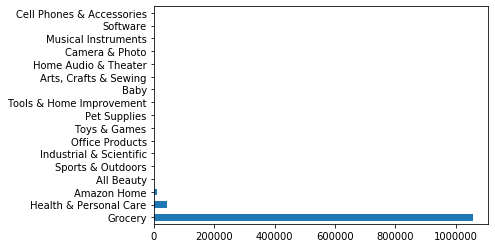

In [23]:
# Посмотрим, как распределяются товары по признаку main_cat
display(df['main_cat'].value_counts())
df['main_cat'].value_counts().plot.barh()

In [24]:
#Почти все товары относятся к категории grocery. Поэтому смело используем ее для заполнения пропусков.
#Позже сделаем на основе этого признака dummy-переменные.
df['main_cat'].fillna('Grocery')

0          Grocery
1          Grocery
2          Grocery
3          Grocery
4          Grocery
            ...   
1114895    Grocery
1114896    Grocery
1114897    Grocery
1114898    Grocery
1114899    Grocery
Name: main_cat, Length: 1114900, dtype: object

Переменные Rank и Category в итоге решил не трогать, т.к. времени на нх уже совсем не остается

In [25]:
df.drop(['rank','category'], inplace=True, axis=1)

### title,brand

title и brand это тоже связанные переменные. 
Переменная title содержит в себе название бренда, далее идет описание товара.

In [26]:
#Посмотрим, сколько у нас брендов
df.brand.value_counts()

KIND                              30079
Bob's Red Mill                    17727
Planters                          13858
Twinings                          12200
Green Mountain Coffee Roasters     9015
                                  ...  
Factory Card and Party Outlet         1
Appian Way                            1
cocomama                              1
Mallo Cup                             1
Novus Tea                             1
Name: brand, Length: 8869, dtype: int64

Всего 8869 брэндов. Сделаем бинарный признак, которые будет показывать, входит ли бренд в топ-500 брендов или нет. Затем на этапе подготовки к ML сделаем также dummy-переменные.

In [27]:
#Пропуски заполняем именем значением 'KIND'
df.brand.fillna('KIND')

0          Primal Palate Organic Spices
1                            Swiss Miss
2                                Torani
3                              Frontier
4                         Miss Vickie's
                       ...             
1114895                    Natural Mate
1114896           Doctor In The Kitchen
1114897                   Peet's Coffee
1114898                     We Got Nuts
1114899               Hoosier Hill Farm
Name: brand, Length: 1114900, dtype: object

Переменную title оставим как есть, т.к. именно ее значения мы будем рекомендовать.

### Анализ категориальных переменных

Анализ категориальных переменных лучше всего провести с помощью теста Стьюдента

In [28]:
for col in ['verified', 'brand','main_cat','weekday','day','month','year']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки verified
Найдены статистически значимые различия для колонки brand
Найдены статистически значимые различия для колонки main_cat
Найдены статистически значимые различия для колонки weekday
Найдены статистически значимые различия для колонки month
Найдены статистически значимые различия для колонки year


В принципе, почти для всех переменных статичтически значимые различия присутствуют.

In [29]:
df

,verified,reviewTime,asin,unixReviewTime,userid,itemid,rating,sample,title,brand,main_cat,weekday,day,month,year
0,1,2016-10-04,B01CPNIEQG,1475539200,102179,37138,1,1,"Primal Palate Organic Spices Adobo Seasoning, ...",Primal Palate Organic Spices,Grocery,Tuesday,4,10,2016
1,1,2016-03-01,B006F63M8U,1456790400,3625,17322,1,1,Milk Chocolate Swiss Miss Hot Cocoa Mix 60-0.7...,Swiss Miss,Grocery,Tuesday,1,3,2016
2,1,2016-06-26,B00112O8NG,1466899200,39495,5600,1,1,"Torani Syrup, Sugar Free Vanilla, 25.4 oz",Torani,Grocery,Sunday,26,6,2016
3,1,2013-09-05,B00MRAQUM8,1378339200,72854,30249,1,1,Frontier Herb Organic Powdered Ceylon Cinnamon...,Frontier,Grocery,Thursday,5,9,2013
4,1,2016-09-14,B000R7RN0G,1473811200,74859,4349,1,1,Miss Vickie's Jalapeño Flavored Kettle Cooked ...,Miss Vickie's,Grocery,Wednesday,14,9,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114895,1,2016-01-17,B00FLD3X28,1452988800,294,25601,0,0,"Natural Mate Sweetener, Sucralose and Erythrit...",Natural Mate,Grocery,Sunday,17,1,2016
1114896,1,2015-08-22,B0078DQ85S,1440201600,119653,18204,0,0,"Doctor In The Kitchen, Flackers Organic Flax S...",Doctor In The Kitchen,Grocery,Saturday,22,8,2015
1114897,1,2017-09-21,B000FZVLFS,1505952000,54673,2287,0,0,"Peet's Coffee, French Roast Dark Roast, Whole ...",Peet's Coffee,Grocery,Thursday,21,9,2017
1114898,1,2018-03-27,B001PB801Y,1522108800,16569,9343,0,0,Two Pounds Of Dates Pitted - We Got Nuts,We Got Nuts,Grocery,Tuesday,27,3,2018


### Подготовка данных к ML

In [30]:
#Создаем Dummy-переменные
df = pd.get_dummies(df,columns=['weekday'])
df = pd.get_dummies(df,columns=['day'])
df = pd.get_dummies(df,columns=['month'])
df = pd.get_dummies(df,columns=['year'])
df = pd.get_dummies(df,columns=['brand'])
df = pd.get_dummies(df,columns=['main_cat'])

In [31]:
#Удаляем столбцы asin и reviewTime
df.drop(['reviewTime'], inplace=True, axis=1)

#Возвращаем разбиение датасета на train и test
train = df.query('sample == 1').drop('sample', axis=1)
test = df.query('sample == 0').drop('sample', axis=1)

In [32]:
train

,verified,asin,unixReviewTime,userid,itemid,rating,title,weekday_Friday,weekday_Monday,weekday_Saturday,...,main_cat_Health & Personal Care,main_cat_Home Audio & Theater,main_cat_Industrial & Scientific,main_cat_Musical Instruments,main_cat_Office Products,main_cat_Pet Supplies,main_cat_Software,main_cat_Sports & Outdoors,main_cat_Tools & Home Improvement,main_cat_Toys & Games
0,1,B01CPNIEQG,1475539200,102179,37138,1,"Primal Palate Organic Spices Adobo Seasoning, ...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,B006F63M8U,1456790400,3625,17322,1,Milk Chocolate Swiss Miss Hot Cocoa Mix 60-0.7...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,B00112O8NG,1466899200,39495,5600,1,"Torani Syrup, Sugar Free Vanilla, 25.4 oz",0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,B00MRAQUM8,1378339200,72854,30249,1,Frontier Herb Organic Powdered Ceylon Cinnamon...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,B000R7RN0G,1473811200,74859,4349,1,Miss Vickie's Jalapeño Flavored Kettle Cooked ...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828930,1,B008QMX2SG,1478217600,70292,24556,1,"Kind Bars, Madagascar Vanilla Almond, Gluten F...",1,0,0,...,0,0,0,0,0,0,0,0,0,0
828931,1,B000H7ELTW,1364860800,59433,2566,1,"Traverse Bay Fruit Dried Cranberries, 4 Pound",0,0,0,...,0,0,0,0,0,0,0,0,0,0
828932,0,B000LKX6R8,1474416000,88,3251,1,"Hakubaku Organic Soba, Authentic Japanese Buck...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
828933,1,B00BUKL666,1446336000,41540,22208,1,"KIND Bars, Dark Chocolate Nuts & Sea Salt, Glu...",0,0,0,...,0,0,0,0,0,0,0,0,0,0


### ML

#### Подготовка модели

Разбиваем данные и готовим разреженную матрицу для LightFM.

In [33]:
train_data, test_data = train_test_split(train,random_state=32, shuffle=True)

In [34]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))


Была идея подобрать оптимальные параметры для LightFM в помощью gridsearch, код был написан, но вычислительных мощностей для этого не хватило. Так что параметры для обучения подбирал вручную

In [35]:
#Обучаем модель

NUM_THREADS = 4 #число потоков
NUM_COMPONENTS = 60 #число параметров вектора 
NUM_EPOCHS = 20 #число эпох обучения

model = LightFM(learning_rate=0.085, loss='logistic',learning_schedule='adagrad',
                  no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

In [36]:
# Совершаем предикт

preds = model.predict(test_data.userid.values,
                      test_data.itemid.values)

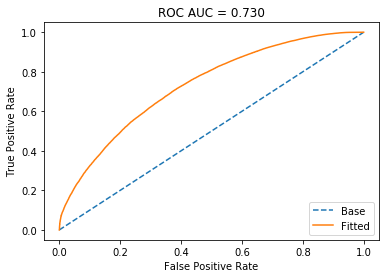

In [37]:
# Строим кривую ROC_AUC для модели с параметрами из бейзлайна
fpr, tpr, threshold = roc_curve(test_data.rating, preds)
roc_auc = sklearn.metrics.roc_auc_score(test_data.rating,preds)

plt.figure()
plt.plot([0, 1], label='Base', linestyle='--')
plt.plot(fpr, tpr, label = 'Fitted')
plt.title('ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
prec_score = precision_at_k(
                     model,
                     ratings_coo,
                     num_threads=NUM_THREADS,
                     k=10).mean()
 
recall_at_k = recall_at_k(model,
                     ratings_coo,
                     num_threads=NUM_THREADS,
                     k=10).mean()

auc_score = auc_score(model,
                     ratings_coo,
                     num_threads=NUM_THREADS).mean()

#### Предсказание на тестовых данных

In [38]:
# Совершаем предикт

preds = model.predict(test.userid.values,
                      test.itemid.values)

In [39]:
#Диаппазон предсказаний
preds.min(), preds.max()

(-30.825289, 32.902954)

In [40]:
#Нормализуем предсказания
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()
normalized_preds.min(), normalized_preds.max()

(0.0, 1.0)

In [41]:
# Получаем submission
submission['rating']= normalized_preds
submission.to_csv('submission.csv', index=False)

### Рекомендательная система

Попробуем посмотреть, как получившаяся модель работает на практике. Сначала получим из нее эмбеддинги

In [42]:
# Достаём эбмеддинги

item_biases, item_embeddings = model.get_item_representations()
item_biases.shape, item_embeddings.shape

((41320,), (41320, 60))

Честно говоря, я плохо понимаю, как работают графы, поэтому просто применим код из лекции.

In [43]:
#Создаём наш граф для поиска
nms_idx = nmslib.init(method='hnsw', space='cosinesimil')
 
#Начинаем добавлять наши товары в граф
nms_idx.addDataPointBatch(item_embeddings)
nms_idx.createIndex(print_progress=True)

In [44]:
#Вспомогательная функция для поиска по графу
def nearest_goods_nms(itemid, index, n=10):
    nn = index.knnQuery(item_embeddings[itemid], k=n)
    return nn

In [45]:
#Попробуем что-нибудь порекомендовать пользователю

train[train.title.str.find('chocolate')>=0].head(5)

,verified,asin,unixReviewTime,userid,itemid,rating,title,weekday_Friday,weekday_Monday,weekday_Saturday,...,main_cat_Health & Personal Care,main_cat_Home Audio & Theater,main_cat_Industrial & Scientific,main_cat_Musical Instruments,main_cat_Office Products,main_cat_Pet Supplies,main_cat_Software,main_cat_Sports & Outdoors,main_cat_Tools & Home Improvement,main_cat_Toys & Games
7245,1,B00GXT7NJ8,1395273600,6256,26561,1,Pernigotti Cocoa - 1 Kg (2.2 lbs) - from the f...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9683,1,B00OBO2GVM,1493251200,28826,31074,1,Atkins endulge pieces - milk chocolate caramel...,0,0,0,...,1,0,0,0,0,0,0,0,0,0
11504,1,B0017OLEMQ,1339372800,21565,6627,1,Sixlets 48 packs of candy coated chocolate candy,0,1,0,...,0,0,0,0,0,0,0,0,0,0
15336,1,B00069IHO6,1447891200,20913,784,1,Milk Chocolate Rocks 3 pound bag (48 ounces of...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19372,1,B0017OLEMQ,1362009600,35367,6627,1,Sixlets 48 packs of candy coated chocolate candy,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
nbm = nearest_goods_nms(27865,nms_idx)[0]

In [47]:
train[train.itemid.isin(nbm)]

,verified,asin,unixReviewTime,userid,itemid,rating,title,weekday_Friday,weekday_Monday,weekday_Saturday,...,main_cat_Health & Personal Care,main_cat_Home Audio & Theater,main_cat_Industrial & Scientific,main_cat_Musical Instruments,main_cat_Office Products,main_cat_Pet Supplies,main_cat_Software,main_cat_Sports & Outdoors,main_cat_Tools & Home Improvement,main_cat_Toys & Games
7943,1,B00OSVGZKG,1432252800,112691,31254,1,"BEANITOS Real Cheesy White Bean Puffs, 3 Ounce...",1,0,0,...,0,0,0,0,0,0,0,0,0,0
13121,1,B01CKEPBAM,1488844800,12065,37100,1,Paleo Baking Company Paleo Vanilla Cake & Muff...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29846,0,B00IV6ITFI,1394841600,49071,27865,1,"Lily's Chocolate, Bar Chocolate Dark Stevia Fa...",0,0,1,...,0,0,0,0,0,0,0,0,0,0
42375,1,B01CKEPBAM,1485993600,31770,37100,0,Paleo Baking Company Paleo Vanilla Cake & Muff...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42450,0,B0009JHVN6,1395532800,8244,962,0,"Gourmet Popping Corn - Case of 15 oz. bottles,...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780548,1,B0193U5QCE,1459123200,87229,36231,1,"Instant Clear Jel, 16 oz.",0,1,0,...,0,0,0,0,0,0,0,0,0,0
801401,1,B0009JHVN6,1412380800,28140,962,1,"Gourmet Popping Corn - Case of 15 oz. bottles,...",0,0,1,...,0,0,0,0,0,0,0,0,0,0
805411,1,B00DGJB0WY,1387324800,6606,23830,1,BEANITOS Restaurant Style White Bean With Sea ...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
806202,1,B00IEFXUSM,1524787200,92911,27520,1,Jolly Rancher Singles to Go - Variety (Pack of...,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Итог

В ходе работы удалось построить более-менее работающую рекомендательную модель, однако рекомендаций очень много, поэтому есть сомнения в корректности работы модели.

В рамках EDA был присоединен дополнительный датасет по признаку asin.

Была обучена модель LightFM, параметры подбирались вручную. Была идея подбирать их с помощью gridsearch, но нагрузка на CPU была очень высокой в течение долгого периода времени, решил от этого отказаться в этом проекте. Достаточно того, что я знаю, как это делать.

Были определены метрики precision, recall и auc. Их значения в целом в рамках нормы. Затем были сделаны предсказания для тестового датасета, сформирован submission и отправлен на kaggle.

В последней части проекта я получил эмбеддинги и использовал их до построения item-based рекомендаций.



